# Test Task

1. Take 2 classes from this dataset (https://www.kaggle.com/datasets/balraj98/modelnet10-princeton-3d-object-dataset)

2. Train a conditional GAN that takes a random noise and the class label (the classes you have selected from the dataset) to create new 3D sample of the class

3. You can use any ML library. Make sure you also write comments in your code so it’s easy to follow.

In [1]:
#import
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def load_data(classes, data_path, target_vertices=1024):
    #Ensures that every 3D model has fixed number of vertices(target_vertices)
    def pad_or_truncate(array, target_vertices):
        if len(array) > target_vertices: #If model has too many vertices : truncates extra vertices
            return array[:target_vertices]
        elif len(array) < target_vertices: #Fewer vertices : Adds Zero padding
            padding = np.zeros((target_vertices - len(array), 3))
            return np.vstack([array, padding])
        return array

    data = {} #store processed 3D models for each class
    for cls in classes:
        class_path = os.path.join(data_path, cls) # Contructing path to the class folder
        if not os.path.exists(class_path):
            print(f"Class folder not found: {class_path}")
            data[cls] = []
            continue

        # Recursively find all .off files in Train and Test subfolders
        files = [] # Collects full paths to all .off files
        for root, _, filenames in os.walk(class_path): 
            files.extend(os.path.join(root, f) for f in filenames if f.endswith('.off'))

        if not files:
            print(f"No .off files found for class {cls} in {class_path}")
            data[cls] = []
            continue

        # Load .off files and normalize data
        class_data = []
        for file_path in files:
            try:
                with open(file_path, 'rb') as file:  # Open in binary mode so that file is read exactly as it is stored on disk
                    content = file.read().decode('ascii', errors='ignore').splitlines()  # Decode as ASCII
                    if not content or content[0].strip() != 'OFF': #Checking for valid .off file
                        print(f"Skipping invalid OFF file: {file_path}")
                        continue

                    num_vertices = int(content[1].split()[0])  # contains Number of vertices and convert it to Numpy array of shape
                    vertices = np.array([list(map(float, content[i + 2].split())) for i in range(num_vertices)])
                    normalized_vertices = pad_or_truncate(vertices, target_vertices) #Normalise data
                    class_data.append(normalized_vertices.flatten()) #Flatten the normalized vertices into single array to simplify data for further processing
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                continue

        data[cls] = class_data #Store list of arrays in a dictionary
        print(f"Loaded {len(class_data)} .off files for class {cls}")
    return data

In [3]:
# 2. Build Generator
def build_generator(latent_dim, num_classes, output_dim):
    noise_input = Input(shape=(latent_dim,)) #Input for random noise vector
    label_input = Input(shape=(1,), dtype='int32') #Input for class label
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label_input)) # Converts class label into dense vector representation of size latent_dim
    combined_input = Concatenate()([noise_input, label_embedding])  #Combine noise input and label embedding into single vector
    
    x = Dense(256, activation="relu")(combined_input)
    x = Dense(512, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(output_dim, activation="linear")(x)
    return Model([noise_input, label_input], x)

In [4]:
# 3. Build Discriminator
def build_discriminator(input_dim, num_classes):
    input_data = Input(shape=(input_dim,))
    label_input = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, input_dim)(label_input))
    combined_input = Concatenate()([input_data, label_embedding])
    
    x = Dense(512, activation="relu")(combined_input)
    x = Dense(256, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model([input_data, label_input], x)

In [5]:
def visualize_results(generator, latent_dim, num_classes):
    fig = plt.figure(figsize=(10, 5))
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    for cls_idx in range(num_classes):
        noise = np.random.normal(0, 1, (1, latent_dim))
        generated_sample = generator.predict([noise, np.array([[cls_idx]])])
        sample = generated_sample.reshape(-1, 3)

        ax = fig.add_subplot(1, num_classes, cls_idx + 1, projection='3d')
        ax.scatter(sample[:, 0], sample[:, 1], sample[:, 2],color=colors[cls_idx % len(colors)], label=f"Class {cls_idx}")
        ax.set_title(f"Class {cls_idx}")
        ax.legend()  # Add legend to identify class
        ax.grid(True)
    plt.show()

In [10]:
def train_cgan(generator, discriminator, latent_dim, data, epochs=50, batch_size=32):
    optimizer = Adam(0.0005, 0.5)
    discriminator.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    noise_input = Input(shape=(latent_dim,))
    label_input = Input(shape=(1,))
    generated_data = generator([noise_input, label_input])
    discriminator.trainable = False
    validity = discriminator([generated_data, label_input])
    combined = Model([noise_input, label_input], validity)
    combined.compile(optimizer=optimizer, loss="binary_crossentropy")
    
    for epoch in range(epochs):
        d_real_acc = []  # Store accuracy for real samples
        d_fake_acc = []  # Store accuracy for fake samples

        for cls_idx, cls in enumerate(data):
            # Real data
            real_data = np.array(data[cls])
            real_labels = np.ones((real_data.shape[0], 1))
            
            # Generate fake data
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_data = generator.predict([noise, np.full((batch_size, 1), cls_idx)], verbose=0)
            fake_labels = np.zeros((batch_size, 1))
            
            # Train the discriminator
            d_loss_real, d_acc_real = discriminator.train_on_batch([real_data, np.full((real_data.shape[0], 1), cls_idx)], real_labels)
            d_loss_fake, d_acc_fake = discriminator.train_on_batch([fake_data, np.full((batch_size, 1), cls_idx)], fake_labels)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)
            
            # Store accuracy
            d_real_acc.append(d_acc_real)
            d_fake_acc.append(d_acc_fake)
        
        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = combined.train_on_batch([noise, np.random.randint(0, len(data), (batch_size, 1))], np.ones((batch_size, 1)))
        
        # Log discriminator accuracy
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f} | D Real Acc: {np.mean(d_real_acc):.4f} | D Fake Acc: {np.mean(d_fake_acc):.4f}")

In [11]:
base_path = "/Users/samarthmhathwar/Desktop/Hiwi/archive/ModelNet10"
classes = ["monitor", "toilet"]
latent_dim = 100
target_vertices = 1024  # Number of vertices per model
input_dim = target_vertices * 3  # Flattened input dimension for discriminator
num_classes = len(classes)

# Load Data
print("Loading data...")
data = load_data(classes, base_path, target_vertices)

# Build Models
print("Building models...")
generator = build_generator(latent_dim, num_classes, output_dim=input_dim)
discriminator = build_discriminator(input_dim, num_classes)

# Train the cGAN
print("Training the model...")
train_cgan(generator, discriminator, latent_dim, data, epochs=100, batch_size=32)

print("Training completed!")

Loading data...
Loaded 565 .off files for class monitor
Loaded 444 .off files for class toilet
Building models...
Training the model...
Epoch 1/100 | D Loss: 0.1789 | G Loss: 0.6187 | D Real Acc: 0.9606 | D Fake Acc: 0.9204
Epoch 2/100 | D Loss: 0.2027 | G Loss: 0.4192 | D Real Acc: 0.9336 | D Fake Acc: 0.9176
Epoch 3/100 | D Loss: 0.2392 | G Loss: 0.2943 | D Real Acc: 0.9271 | D Fake Acc: 0.9170
Epoch 4/100 | D Loss: 0.2819 | G Loss: 0.2222 | D Real Acc: 0.9241 | D Fake Acc: 0.9168
Epoch 5/100 | D Loss: 0.3268 | G Loss: 0.1782 | D Real Acc: 0.9224 | D Fake Acc: 0.9166
Epoch 6/100 | D Loss: 0.3670 | G Loss: 0.1486 | D Real Acc: 0.9213 | D Fake Acc: 0.9165
Epoch 7/100 | D Loss: 0.4015 | G Loss: 0.1275 | D Real Acc: 0.9205 | D Fake Acc: 0.9165
Epoch 8/100 | D Loss: 0.4321 | G Loss: 0.1116 | D Real Acc: 0.9200 | D Fake Acc: 0.9164
Epoch 9/100 | D Loss: 0.4567 | G Loss: 0.0992 | D Real Acc: 0.9195 | D Fake Acc: 0.9164
Epoch 10/100 | D Loss: 0.4773 | G Loss: 0.0893 | D Real Acc: 0.9192 | D 

Visualizing results...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


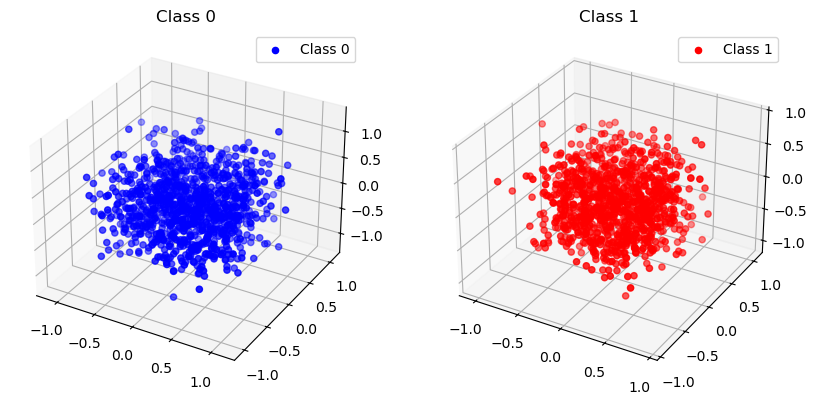

In [12]:
# Visualize Results
print("Visualizing results...")
visualize_results(generator, latent_dim, num_classes)